In [1]:
#Import packages 
import pystan
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()

#Model definition
model = """
data {
    int<lower=0> N; // # data points 
    int<lower=0> K; // # regressors 
    matrix[N, K] x;  // data matrix
    vector[N] y; // predictions
}
parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(x*beta + alpha, sigma);
}
"""

In [21]:
#Load data
fileDir = '/Users/maxaragon/Desktop/stan_demo/mtcars.xls'
dF = pd.read_excel(fileDir)

#Format data
xData = list(np.array([dF[key] for key in dF if key=='hp' or key=='wt']).T)
N,K = np.shape(xData)
yData = dF['mpg']
data = {'N': N, 'K': K, 'x': xData, 'y': yData}

#Compile model
sm = pystan.StanModel(model_code=model)

#Sample from posterior
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b41d20b518ac0642124af70e42c7e1e3 NOW.


Inference for Stan model: anon_model_b41d20b518ac0642124af70e42c7e1e3.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     37.2    0.05   1.71  33.81  36.09  37.25  38.34   40.5   1197    1.0
beta[1]  -0.03  2.7e-4 9.2e-3  -0.05  -0.04  -0.03  -0.03  -0.01   1206    1.0
beta[2]  -3.87    0.02   0.64  -5.14  -4.29  -3.85  -3.43  -2.62   1176    1.0
sigma     2.72    0.01   0.37   2.11   2.46   2.69   2.94   3.59   1178    1.0
lp__    -46.11    0.05   1.49 -49.96 -46.82 -45.77 -45.01 -44.28    881    1.0

Samples were drawn using NUTS at Sat Feb 22 21:34:50 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


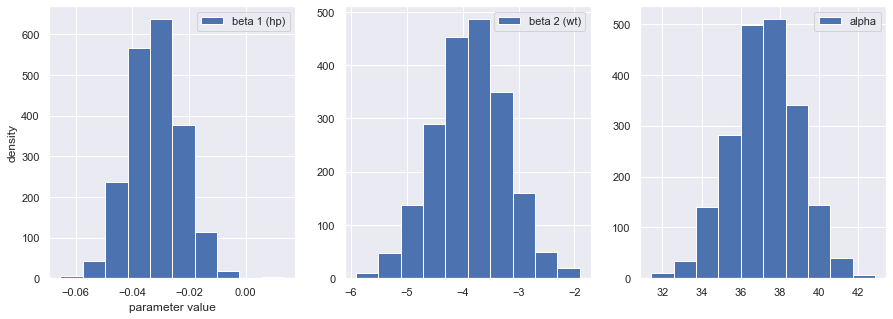

In [118]:
#Display results
print(fit)

#Fitted parameters 
alpha = fit['alpha']
betas = fit['beta'].T

#Plot parameters
fig,ax = plt.subplots(1,3,figsize=(15,5))

betaLabels = ['hp','wt']

for idx,(beta,bl) in enumerate(zip(betas,betaLabels)):
    ax[idx].hist(beta,label = 'beta %d (%s)'%((idx+1),bl))
    ax[idx].legend()
    
    if idx<1:
        ax[idx].set_xlabel('parameter value')
        ax[idx].set_ylabel('density')

ax[2].hist(alpha,label = 'alpha')
ax[2].legend()
plt.show()


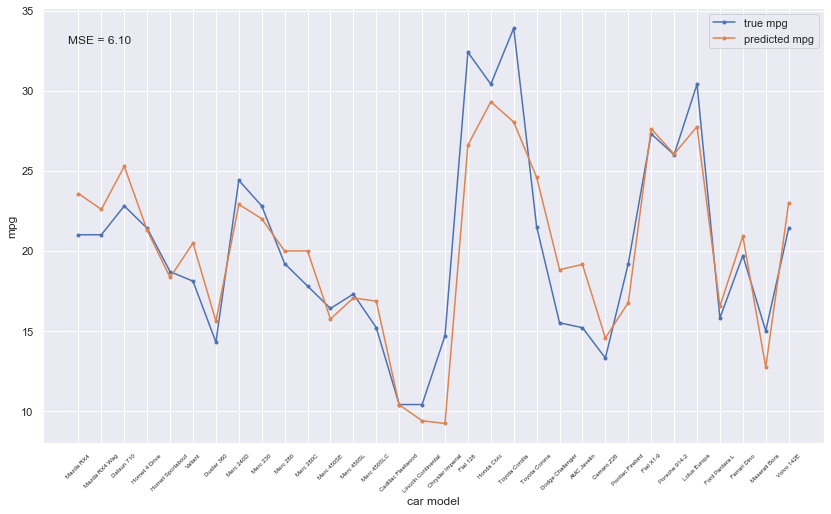

In [108]:
#Error metric function
MSE = lambda y,y_hat: len(y)**-1 * np.sum([(yi - yi_hat)**2 for yi,yi_hat in zip(y,y_hat)])

#Posterior prediction function
predict = lambda x,beta: [beta[0] + np.sum(beta[1:]*x_i) for x_i in x]

#Compute mean statistics
muAlpha = np.mean(fit['alpha'])
muBeta = []

for beta in betas:
    muBeta.append(np.mean(beta))
    
muBetas = np.array([muAlpha] + muBeta)
    
#Predict mpg
y_hat = predict(np.array(xData),muBetas)
error = MSE(yData,y_hat)

#Plot real and predicted data 
carModels = dF['model']
ticks = np.arange(len(carModels))

fig,ax = plt.subplots(figsize= (14,8))
ax.plot(yData,'.-',label='true mpg')
ax.plot(y_hat,'.-',label = 'predicted mpg') 
ax.set_xlabel('car model')
ax.set_ylabel('mpg')
ax.tick_params(axis='x', which='major', labelsize=6, rotation = 45)
plt.xticks(ticks, [model for model in carModels])
plt.figtext(.15,.82, 'MSE = %.2f' %error)
plt.legend()
plt.show()
    
